<a href="https://colab.research.google.com/github/mkpvasu/Brain-Tumor-Classification/blob/main/BT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [3]:
#Emptying the device's cache
torch.cuda.empty_cache()

In [4]:
# Preparing an augmented dataset for more robust model

class BrainTumorDataset(Dataset):
  def __init__(self, images, labels):
    # Images
    self.X = images
    # Corresponding Labels
    self.y = labels
    
    # Convert original image numpy array to PIL image and then to a tensor
    self.transform = transforms.Compose([transforms.ToPILImage(),
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ])

    # Augmenting original image numpy array by resizing it to (64,64) pixels, then rotating it to randomly between [-k,k] degrees and 
    # then convert it to tensor
    self.transform30 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128,128)),                                         
        transforms.RandomRotation(30),
        transforms.ToTensor()                                 
    ])

    self.transform90 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128,128)),
        transforms.RandomRotation(90),
        transforms.ToTensor()                                  
    ])

    self.transform135 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128,128)),
        transforms.RandomRotation(135),
        transforms.ToTensor()                                  
    ])

    self.transform180 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128,128)),
        transforms.RandomRotation(180),
        transforms.ToTensor()                                
    ])

    self.transform270 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128,128)),
        transforms.RandomRotation(270),
        transforms.ToTensor()                                
    ])

    # self.transform315 = transforms.Compose([
    #     transforms.ToPILImage(),
    #     transforms.Resize((64,64)),
    #     transforms.RandomRotation(315),
    #     transforms.ToTensor()                                
    # ])
    
    # self.transform345 = transforms.Compose([
    #     transforms.ToPILImage(),
    #     transforms.Resize((64,64)),
    #     transforms.RandomRotation(345),
    #     transforms.ToTensor()                                
    # ])

  def __len__(self):
    # Returns # of images
    return len(self.X)

  def __getitem__(self, idx):
    # Transformations for one image of X at a time
    # Original image as a tensor
    img = self.transform(self.X[idx])

    # Transformations are called to augment images and save it to traing the model
    img30 = self.transform30(self.X[idx])
    img90 = self.transform90(self.X[idx])
    img135 = self.transform135(self.X[idx])
    img180 = self.transform180(self.X[idx])
    img270 = self.transform270(self.X[idx])
    # img315 = self.transform270(self.X[idx])  
    # img345 = self.transform270(self.X[idx])    
    
    # store the transformed images in a list
    batch = [img, img30, img90, img135, img180, img270]

    # One Hot Encoding is used here to give the respective column of the image label 1.0 and other columns as 0.0
    labels = torch.zeros(4, dtype=torch.float32)
    labels[int(self.y[idx])] = 1.0

    b_labels = [labels, labels, labels, labels, labels, labels]

    # 8 augmented images and corresponding labels per sample will be returned
    return (torch.stack(b_labels), torch.stack(batch))

In [5]:
train_data = pickle.load(open('/content/Drive/My Drive/Colab Notebooks/braintumordata/train_data.pickle', 'rb'))

In [6]:
Xt, yt, label= [], [], []
features, labels = None, None

In [7]:
for features,labels in train_data:
  Xt.append(features)
  yt.append(labels)

In [8]:
# The train_data has been divided into training, validation and testing data
# 75% - training data
# 15% - validation data
# 10% - testing data

X_train, X_test, y_train, y_test = train_test_split(Xt, yt, test_size=0.25, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.6, shuffle=True)

In [9]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 2298
Number of validation samples: 306
Number of testing samples: 460


In [10]:
print(f"Number of augmented training samples: ",(len(X_train) * 6))
print(f"Number of augmented validation samples: ", (len(X_val)* 6))
print(f"Number of augmented testing samples: ", (len(X_test)* 6))

Number of augmented training samples:  13788
Number of augmented validation samples:  1836
Number of augmented testing samples:  2760


In [11]:
# Clearing memory
Xt, yt, labels, label, features, train_data = None, None, None, None, None, None

In [12]:
# To augmented dataset and save it to corresponding variables

train_set = BrainTumorDataset(X_train, y_train)
val_set = BrainTumorDataset(X_val, y_val)
test_set = BrainTumorDataset(X_test, y_test)

In [13]:
# These dataloaders load the dataset to minimize the time device has to wait to retrieve data

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True, pin_memory=True, num_workers=8)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True, pin_memory=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
# Giving the variable device to device name of the GPU connected
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

In [15]:
# Using Resnet50 (50 layers) pretrained model (this model will be pretrined using ImageNet dataset) as our model
resnet_50 = models.resnet50(pretrained=True)

# Training all parameters
for param in resnet_50.parameters():
    param.requires_grad = True

# Input for fully connected layer
n_inputs = resnet_50.fc.in_features

# Creating a new final fully connected layer to make this model perform classification for our dataset (Original pretrined model can classify the 
# classes it was trained on)
resnet_50.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 4),
                                nn.LogSigmoid())

# Training all parameters
for name, child in resnet_50.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

# Model will run on GPU if available else CPU
resnet_50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# Cross Entropy loss is used for classification algorithm here as it is common
# GPU is used if available for faster training
crossen_loss = nn.CrossEntropyLoss().to(device)

# Stochastic Gradient Descent optimizer and the specified parameters are generally preferred while using SGD
sgd_opt = torch.optim.SGD(resnet_50.parameters(), momentum=0.9, lr=3e-4)

# # of epochs to be trained
epochs = 30

# Lists to store train, test losses and accuracies
train_losses, val_losses, train_accs, val_accs = [],[],[],[]

In [17]:
def save_model(state, is_best, filename='/content/Drive/My Drive/Colab Notebooks/braintumordata/bt_resnet50_bt_intermodel.pth.tar'):
    torch.save(state, filename)

In [19]:
# This can be used to time your entire ruuning time for the process
start_time = time.time()

# Inorder to save the model at certain intervals the best_training loss should be a minimum of 2 else the model won't get saved
best_prec_loss = 2

# Batch Variables
b = None
train_b = None
test_b = None

# Training
for i in range(epochs):
    # Training Correct and Validation Correct is updated to 0 during every iteration
    train_corr = 0
    val_corr = 0
    
    # Timing Epoch: starting epoch time
    e_start = time.time()
    
    # Batch Training
    for b, (y, X) in enumerate(train_loader):
        # Transfer variables to the device if available
        X, y = X.to(device), y.to(device)

        # Forward passing image
        y_pred = resnet_50(X.view(-1, 3, 128, 128))
        # Loss calculation
        loss = crossen_loss(y_pred.float(), torch.argmax(y.view(-1, 4), dim=1).long())

        # The argmax of the predicted tensor is assigned as our label
        mod_pred = torch.argmax(y_pred, dim=1).data

        # # of correctly predicted images in a batch is equal to the sum of all correctly predicted images
        batch_corr = (mod_pred == torch.argmax(y.view(-1, 4), dim=1)).sum()

        # Batch correct is added to train correct for tracking the # of correctly predicted labels of the training data
        train_corr += batch_corr
        
        # Setting SGD opt gradient to zero
        sgd_opt.zero_grad()

        # Back propagation based on the loss to update weights to improve learning
        loss.backward()

        # Performing the increment in weights by taking a step
        sgd_opt.step()

    # Epoch end time
    e_end = time.time()
    # Output: Training Metrics
    print(f'Current Epoch: {(i+1)} Running Batch: {(b+1)*4} \nTraining Accuracy: {train_corr.item()*100/(4*6*b):2.2f} %  Training Loss: {loss.item():2.4f}  Training Duration: {((e_end-e_start)/60):.2f} minutes') # 4 images per batch * 8 augmentations per image * batch length

    # Storing the training losses and correct to plot graph between losses and predicted corrects with batch
    train_b = b
    train_losses.append(loss)
    train_accs.append(train_corr)

    X, y = None, None

    # Validation using val_loader data
    # The backpropagation isn't performed as it is validation data
    with torch.no_grad():
        for b, (y, X) in enumerate(val_loader):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)

            # forward pass image
            y_val = resnet_50(X.view(-1, 3, 128, 128))

            # The argmax of the predicted tensor is assigned as our label
            mod_pred = torch.argmax(y_val, dim=1).data

            # Batch correct is added to validation correct for tracking the # of correctly predicted labels of the validation data
            val_corr += (mod_pred == torch.argmax(y.view(-1, 4), dim=1)).sum()

    # Loss of validation set
    loss = crossen_loss(y_val.float(), torch.argmax(y.view(-1, 4), dim=1).long())
    # Output validation metrics
    print(f'Validation Accuracy {val_corr.item()*100/(4*6*b):2.2f} Validation Loss: {loss.item():2.4f}\n')

    # Saves model if the current validation loss less than the previous validation loss
    best = loss < best_prec_loss
    best_prec_loss = min(loss, best_prec_loss)
    save_model({
            'epoch': i + 1,
            'state_dict': resnet_50.state_dict(),
            'best_prec1': best_prec_loss,
        }, best)

    # Storing the validation losses and correct to plot graph between losses and predicted corrects with batch
    val_b  = b
    val_losses.append(loss)
    val_accs.append(val_corr)

# Training process's end time
end_time = time.time() - start_time    

# Total training duration
print("\nTraining Duration {:.2f} minutes".format(end_time/60))

Current Epoch: 1 Running Batch: 2300 
Training Accuracy: 80.62 %  Training Loss: 0.1883  Training Duration: 0.94 minutes
Validation Accuracy 79.06 Validation Loss: 0.1008

Current Epoch: 2 Running Batch: 2300 
Training Accuracy: 83.83 %  Training Loss: 2.5855  Training Duration: 0.87 minutes
Validation Accuracy 85.53 Validation Loss: 1.0974

Current Epoch: 3 Running Batch: 2300 
Training Accuracy: 87.84 %  Training Loss: 3.1493  Training Duration: 0.95 minutes
Validation Accuracy 87.61 Validation Loss: 0.0600

Current Epoch: 4 Running Batch: 2300 
Training Accuracy: 88.96 %  Training Loss: 0.1003  Training Duration: 0.80 minutes
Validation Accuracy 91.56 Validation Loss: 0.1425

Current Epoch: 5 Running Batch: 2300 
Training Accuracy: 92.63 %  Training Loss: 0.1851  Training Duration: 0.82 minutes
Validation Accuracy 88.98 Validation Loss: 0.3547

Current Epoch: 6 Running Batch: 2300 
Training Accuracy: 92.91 %  Training Loss: 2.2677  Training Duration: 0.77 minutes
Validation Accuracy

In [20]:
torch.cuda.empty_cache()
torch.save(resnet_50.state_dict(), '/content/Drive/My Drive/Colab Notebooks/braintumordata/bt_resnet50_model.pt')

In [21]:
print(f'Validation accuracy: {val_accs[-1].item()*100/(val_b*6*4):.2f}%')

Validation accuracy: 97.92%


In [22]:
train_losses_cpu = np.zeros(30, dtype=np.float32)
val_losses_cpu = np.zeros(30, dtype=np.float32)

for i in range(len(train_losses)):
  train_losses_cpu[i] = train_losses[i].cpu().data.numpy()
  val_losses_cpu[i] = val_losses[i].cpu().data.numpy()

# print(train_losses_cpu)
# print(val_losses_cpu)

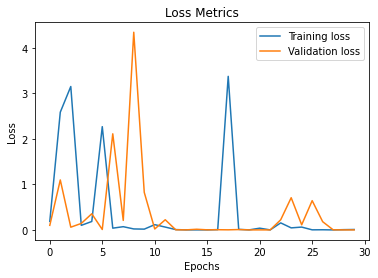

In [23]:
plt.plot(train_losses_cpu, label='Training loss')
plt.plot(val_losses_cpu, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [24]:
train_accs_cpu = np.zeros(30, dtype=np.float32)
val_accs_cpu = np.zeros(30, dtype=np.float32)

for i in range(len(train_accs_cpu)):
  train_accs_cpu[i] = train_accs[i].data.cpu().numpy()
  val_accs_cpu[i] = val_accs[i].cpu().data.numpy()

# print(train_accs_cpu)
# print(val_accs_cpu)

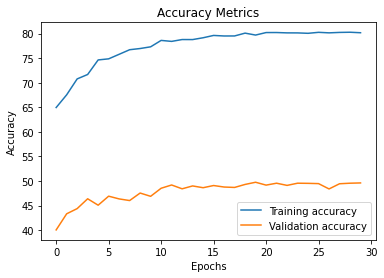

In [25]:
plt.plot([t/171 for t in train_accs_cpu], label='Training accuracy')
plt.plot([t/36 for t in val_accs_cpu], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [26]:
train_loader, val_loader, train_set, val_set = None, None, None, None

In [27]:
# Setting model to evaluation mode
resnet_50.eval()

# No weight updates
with torch.no_grad():
    # soem metrics storage for visualization and analysis
    test_pred = 0
    test_loss, test_corr, labels, pred = [],[],[],[]

    # Batch wise test set evaluation
    for (y, X) in test_loader:
        # Use GPU if available
        X, y = X.to(device), y.to(device)

        # Original labels
        labels.append(torch.argmax(y.view(10*6, 4), dim=1).data)

        # Forward pass
        y_val = resnet_50(X.view(-1, 3, 128,128))

        # The argmax of the predicted tensor is assigned as our label
        pred_label = torch.argmax(y_val, dim=1).data

        # Predicted label addition to the list
        pred.append(pred_label)

        # Compute loss
        loss = crossen_loss(y_val.float(), torch.argmax(y.view(10*6, 4), dim=1).long())

        # Adding the total correct predicted per batch to overall correct predictions
        test_pred += (pred == torch.argmax(y.view(10*6, 4), dim=1)).sum()

        # Storing correct 
        test_corr.append(test_pred)
        test_loss.append(loss)
        
print(f"Test Loss: {test_loss[-1].item():.4f}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Loss: 0.0043


In [28]:
print(f'Test accuracy: {test_corr[-1].item()*100/(460*6):.2f}%')

Test accuracy: 98.88%


In [29]:
labels = torch.stack(labels)
pred = torch.stack(pred)

In [30]:
LABELS = ['Meningioma', 'Glioma', 'Pitutary']

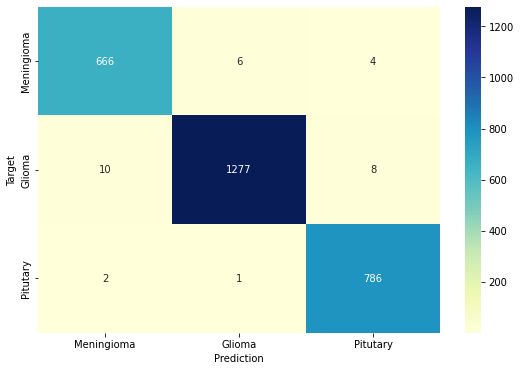

In [31]:
conf_matrix = confusion_matrix(pred.view(-1).cpu(), labels.view(-1).cpu())
df_cm = pd.DataFrame(conf_matrix, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='YlGnBu')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

In [32]:
print(f"Clasification Report\n\n{classification_report(pred.view(-1).cpu(), labels.view(-1).cpu())}")

Clasification Report

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       676
           2       0.99      0.99      0.99      1295
           3       0.98      1.00      0.99       789

    accuracy                           0.99      2760
   macro avg       0.99      0.99      0.99      2760
weighted avg       0.99      0.99      0.99      2760

